In [66]:
import numpy as np
import matplotlib.pyplot as plt

In [456]:
from numba import jit,prange

Create OU process

In [106]:
def ornstein_uhlenbeck(mlam,gamma,sig,length=30,ncel=10,dt=3.):
    mat = np.zeros((ncel,length))
    dW = np.random.normal(loc=mat,scale=np.sqrt(dt))
    mat[:,0]=mlam+sig*dW[:,0]
    for k in range(1,length):
        mat[:,k]=mat[:,k-1]-gamma*(mat[:,k-1]-mlam)*dt+sig*dW[:,k-1]
    return mat

In [353]:
def integrated_ou(mlam,gamma,sig,sigm2,X0=1,sx0=0.1,length=30,ncel=10,dt=3.):
    X = ornstein_uhlenbeck(mlam,gamma,sig,length,ncel,dt)
    X0 = np.random.normal(loc=np.ones((ncel,1)),scale=sx0)
    return np.random.normal(loc=np.hstack([X0,np.cumsum(X,axis=1)*dt+X0]),scale=np.sqrt(sigm2))[:,:-1], X

Length inference

In [419]:
@jit(nopython=True)
def parameters(gamma,dt,mlam,sig_l_s):
    """return F,A, a as in Erik theory paper """
    A = np.empty((2,2))
    A[0,0] =  sig_l_s/(2*gamma**3)*\
            (2*gamma*dt-3+4*np.exp(-gamma*dt)-np.exp(-2*gamma*dt))
    A[1,1] = sig_l_s/(2*gamma)*(1-np.exp(-2*gamma*dt))
    A[0,1] = sig_l_s/(2*gamma**2)*(1-np.exp(-gamma*dt))**2
    A[1,0] = A[0,1]

    F = np.empty((2,2))
    F[0,0] = 1 
    F[0,1] = (1-np.exp(-gamma*dt))/gamma
    F[1,0] = 0 
    F[1,1] = np.exp(-gamma*dt)

    a = np.empty((2,1))
    a[0,0] = mlam/gamma*(np.exp(-gamma*dt)-(1-gamma*dt))
    a[1,0] = mlam*(1-np.exp(-gamma*dt))

    return F, A, a

@jit(nopython=True)
def new_mean_cov(mu, M,F,A,a):
    """From old mean mu and cov M return new one"""
    # No numpy modules for speed up in numba
    #mu_ = a + np.matmul(F,mu)
    #Q = A+np.matmul(F,np.matmul(M,F.T))
    mu_ = a + np.array([[F[0,0]*mu[0,0]+F[0,1]*mu[1,0]],\
                        [F[1,0]*mu[0,0]+F[1,1]*mu[1,0]]])
    T = np.array([[M[0,0]*F[0,0]+M[0,1]*F[0,1],M[0,0]*F[1,0]+M[0,1]*F[1,1]],\
              [M[1,0]*F[0,0]+M[1,1]*F[0,1],M[1,0]*F[1,0]+M[1,1]*F[1,1 ]]])
    T_ = np.array([[F[0,0]*T[0,0]+F[0,1]*T[1,0],F[0,0]*T[0,1]+F[0,1]*T[1,1]],\
                  [F[1,0]*T[0,0]+F[1,1]*T[1,0],F[1,0]*T[0,1]+F[1,1]*T[1,1]]])
    Q = A + T_
    return mu_, Q

@jit(nopython=True)
def posteriori_matrices(x,m,Q,sig_m_s):
    """From updated mu, M return mean and cov of posterior (wich is normal dist)"""
    den = sig_m_s+Q[0,0]
    mu_ = np.zeros_like(m);
    M_ = np.zeros_like(Q)
    mu_[1,0] = m[1,0]+Q[0,1]/den*(x-m[0,0]) #mean lambda t+dt
    mu_[0,0] = (sig_m_s*m[0,0]+Q[0,0]*x)/den #mean x t+dt
    M_[0,0] = sig_m_s*Q[0,0]/den    #var x t+dt
    M_[1,1] = Q[1,1] - Q[0,1]*Q[0,1]/den # var lam t+dt
    M_[0,1] = Q[0,1]*sig_m_s/den
    M_[1,0] = M_[0,1]
    return mu_, M_

@jit(nopython=True)
def log_likelihood(x,m,Q,sig_m_s):
    """Return P(x_{t+dt}|D_t) in log """
    den = sig_m_s+Q[0,0]
    return -(x-m[0,0])**2/(2*den)-0.5*(np.log(den)+np.log(2*np.pi))


Objective function 

In [483]:
def objective(W,mlam,gamma,sig2,sm2,dt,m0,M0):
    ll = 0
    F, A, a = parameters(gamma,dt,mlam,sig2)
    for k in range(W.shape[0]):
        ll += log_p0(W[k,0],sm2)
        m,Q = new_mean_cov(m0, M0,F,A,a)
        for j in range(W.shape[1]):
            ll += log_likelihood(W[k,j],m,Q,sm2)
            mu, M = posteriori_matrices(W[k,j],m,Q,sm2)
            m,Q = new_mean_cov(mu, M,F,A,a)
    return -ll
def posterior(W,mlam,gamma,sig2,sm2,dt,m0,M0):
    F, A, a = parameters(gamma,dt,mlam,sig2)
    z = []; err_z = []
    for k in range(W.shape[0]):
        m,Q = new_mean_cov(m0, M0,F,A,a)
        for j in range(W.shape[1]):
            mu, M = posteriori_matrices(W[k,j],m,Q,sm2)
            z.append(mu); err_z.append(np.array([M[0,0],M[1,1]]))
            m,Q = new_mean_cov(mu, M,F,A,a)
    return z, err_z

In [470]:
np.arange(2).ndim

1

### Main

In [162]:
from scipy.optimize import minimize

In [478]:
np.random.seed(1)
W,X = integrated_ou(mlam=1.,gamma=0.02,sig=.03,sigm2=0.08,length=100000,ncel=1,dt=3.)

Initialize the probabilies

In [480]:
m0 = np.array([[np.mean(W[:,0])],[np.mean(X[:,0])]])
M0 = np.array([[np.var(W[:,0]),0],[0,np.var(X[:,0])]])
log_p0 = lambda x,sm2: -(x-np.mean(W[:,0]))**2/(2*sm2)-0.5*np.log(sm2)-np.log(2*np.pi)

###### Test if looks correct

In [232]:
fun = lambda x: objective(W,mlam=x,gamma=0.02,sig2=.03**2,sm2=0.08,dt=3.,m0=m0,M0=M0)

In [233]:
la = np.arange(0.9,1.1,0.001)
F = [fun(l) for l in la]

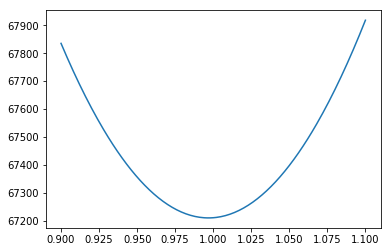

In [234]:
plt.plot(la,F)

In [235]:
fun = lambda x: objective(W,mlam=1,gamma=x,sig2=.03**2,sm2=0.08,dt=3.,m0=m0,M0=M0)

In [236]:
ga = np.arange(0.01,0.03,0.0001)
G = [fun(l) for l in ga]

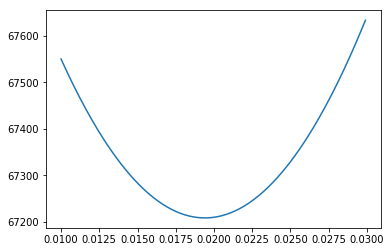

In [237]:
plt.plot(ga,G)

In [255]:
fun = lambda x: objective(W,mlam=1,gamma=0.02,sig2=x,sm2=0.08,dt=3.,m0=m0,M0=M0)

In [239]:
six2 = np.arange(0.0001,0.0018,0.0001)
S = [fun(l) for l in six2]

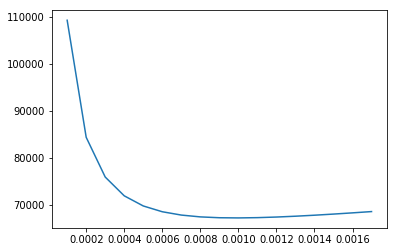

In [268]:
plt.plot(six2,S1)

In [241]:
fun = lambda x: objective(W,mlam=1,gamma=0.02,sig2=.03**2,sm2=x,dt=3.,m0=m0,M0=M0)

In [242]:
sim2 = np.arange(0.07,0.09,0.0001)
Sm = [fun(l) for l in sim2]

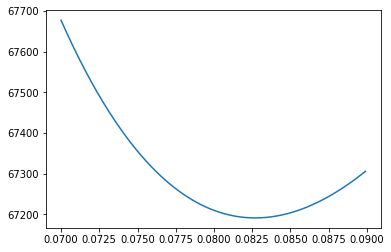

In [243]:
plt.plot(sim2,Sm)

###### Look if posterior are reasonables

In [422]:
z = np.hstack(z)
err_z= np.sqrt(err_z)
err_z = err_z.T

Check when predicted z+/-err is out of true one 

In [423]:
def W_er(st):
    diffW= abs(W-z[0,:])
    percW = sum(sum(diffW>st*err_z[0,:]))/diffW.shape[1]
    return percW

In [424]:
def X_er(st):
    diffX= abs(X-z[1,:])
    percX = sum(sum(diffX>st*err_z[1,:]))/diffW.shape[1]
    return percX

In [427]:
print(W_er(2),X_er(2))

0.01073 0.0909


They look good
